<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Feature Selection </h2>	


<h4> In this section, we would like you to select between 15 and 20 features to focus your model on. This will require significant explatoratory research. The first one is already implemented for you, and the next two are pre-specified.  </h4>

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import skimage
from skimage import data, io
import skimage.feature as ft
import os
from pathlib import Path
import seaborn as sns
from skimage.color import rgb2gray,rgb2xyz,rgb2hsv
from numpy.linalg import det,norm

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# sns.set(style="whitegrid", palette="muted")
%matplotlib inline

folder_names_list = ['airplanes', 'bear', 'blimp', 'comet', 'crab', 'dog', 'dolphin', 'giraffe', 'goat', 'gorilla', 'kangaroo', 'killer-whale', 'leopards', 'llama', 'penguin', 'porcupine', 'teddy-bear', 'triceratops', 'unicorn', 'zebra']

def EDA_bar_plot(df,feature,x='image_type'):
    plot = sns.barplot(x=x,y=feature,data=df)
    plot.set_xticklabels(plot.get_xticklabels(),rotation=90);
    plt.savefig('features/'+feature+'.png',bbox_inches='tight')
    plt.show()
    
def spread(arr):
    return np.max(arr) - np.min(arr)

def normalize(arr):
    return (arr - np.mean(arr))/np.std(arr) ## returns array normalized to mean=0, variance=1

def project_color(image,color):
    ### projects the given image onto a vector in RGB colorspace.
    color = np.array(color)
    assert color.shape[0]==3 
    c_hat = color /  norm(color) ## unit vector
    
    Red = image[:,:,0]
    Green = image[:,:,1]
    Blue = image[:,:,2]
    
    eps = 1e-4 ## pixels are FLOATS!
    pixel_norms = np.sqrt(Red**2 + Green**2 + Blue**2)
    pixel_norms[pixel_norms < eps] = 1. ## avoid divide by 0 errors

    new_channel = (c_hat[0] * Red + c_hat[1] * Green + c_hat[2] * Blue) / pixel_norms
    return new_channel

In [266]:
### Load the training data frame
### WARNING - VERY SLOW
data_file = Path('/Users/will/Documents/Berkeley/Classes/DS100/Projects/GradProject', "labeled_pics.hdf") # Path of hdf file
train_df = pd.read_hdf(data_file, "starting_data")

train_df['shape'] = train_df.Pictures.apply(lambda x: x.shape)
train_df['image_type'] = train_df.Encoding.apply(lambda x: folder_names_list[x])
train_df = train_df.sort_values('image_type')

### Handle gray images, and produce more gray images from the colored ones by grayscaling them.
gray = (train_df['shape'].apply(len) == 2) ## where gray images are in the set
train_df_gray = train_df[gray] # gray images
train_df = train_df[~gray] # train_df is now only color

train_df_grayed = train_df.copy() ## train_df_gray is all gray images + grayed(color images)
train_df_grayed['Pictures'] = train_df_grayed.Pictures.apply(rgb2gray)
train_df_gray.append(train_df_grayed,ignore_index=True)

train_df.head()

,Pictures,Encoding,shape,image_type
284,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,"(228, 396, 3)",airplanes
314,"[[[255, 255, 255], [253, 254, 255], [248, 255,...",0,"(195, 396, 3)",airplanes
313,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,"(205, 392, 3)",airplanes
311,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,"(192, 392, 3)",airplanes
310,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,"(155, 391, 3)",airplanes


In [267]:
### FEATURES ### 

def ft0(image):
    return image.size
# Returns the pixel size of the image

def ft1(image):
    ### channel labels: 0=red, 1=green, 2=blue
    if len(image.shape) == 3: ## if it has color channels
        return np.mean(image[:,:,0])
    else:
        return 0. ## grayscale images
# Returns the average of the red-channel pictures for the images

def ft2(image):
    ### aspect ratio = width / height
    return image.shape[1]/image.shape[0]
#Returns the aspect ratio of the image

def avg_green(image):
    ### channel labels: 0=red, 1=green, 2=blue
    if len(image.shape) == 3: ## if it has color channels
        return np.mean(image[:,:,1])
    else:
        return 0. ## grayscale images
# Returns the average of the green-channel pictures for the images

def avg_blue(image):
    ### channel labels: 0=red, 1=green, 2=blue
    if len(image.shape) == 3: ## if it has color channels
        return np.mean(image[:,:,2])
    else:
        return 0. ## grayscale images
# Returns the average of the blue-channel pictures for the images

def avg_HSV(image): ### note: assumed input is in RGB!
    ### Returns average hue, saturation, brightness values. (HSV color space)
    ### channel labels: 0=hue, 1=saturation, 2=brightness
    hsv_im = rgb2hsv(image)
    return [np.mean(hsv_im[:,:,0]),np.mean(hsv_im[:,:,1]),np.mean(hsv_im[:,:,2])]

def avg_hue(image): ### note: assumed input is in RGB!
    ### Returns average hue value.
    ### channel labels: 0=hue, 1=saturation, 2=brightness
    if len(image.shape) == 3:
        return np.mean(rgb2hsv(image)[:,:,0])
    
def avg_sat(image): ### note: assumed input is in RGB!
    ### Returns average saturation value.
    ### channel labels: 0=hue, 1=saturation, 2=brightness
    if len(image.shape) == 3:
        return np.mean(rgb2hsv(image)[:,:,1])
    
def avg_bright(image): ### note: assumed input is in RGB!
    ### Returns average brightness value.
    ### channel labels: 0=hue, 1=saturation, 2=brightness
    if len(image.shape) == 3:
        return np.mean(rgb2hsv(image)[:,:,2])
    
def corr(A,B):
    return np.corrcoef(A.flatten(),B.flatten())[0,1]
    #if A,B not flat, flatten them, then calculates the correlation
    
def rgcorr(image):
    red = normalize(image[:,:,0])
    green = normalize(image[:,:,1])
    return corr(red,green)
#Returns the correleation between the red and the green channels

def rbcorr(image):
    red = normalize(image[:,:,0])
    blue = normalize(image[:,:,2])
    return corr(red,blue)
#Returns the correleation between the red and the blue channels

def gbcorr(image):
    green = normalize(image[:,:,1])
    blue = normalize(image[:,:,2])
    return corr(green,blue)
#Returns the correleation between the red and the blue channels  

def dominant_colors(image,ncolors):
    ### Uses K-Means clustering to return the most dominant colors in an image.
    from sklearn.cluster import KMeans
    clt = KMeans(n_clusters=ncolors) #cluster number
    clt.fit(image.reshape((image.shape[0] * image.shape[1],3)))
    return(clt.cluster_centers_)

def avg_color(image,color):
    return np.mean(project_color(image,color))

def avg_XYZ(image): ### note: assumed input is in RGB!
    ### Returns average X,Y,Z values. (XYZ color space)
    ### channel labels: 0=X, 1=Y, 2=Z
    xyz_im = rgb2xyz(image)
    return [np.mean(xyz_im[:,:,0]),np.mean(xyz_im[:,:,1]),np.mean(xyz_im[:,:,2])]

def avg_X(image): ### note: assumed input is in RGB!
    ### Returns average X value. (XYZ color space)
    ### channel labels: 0=X, 1=Y, 2=Z
    if len(image.shape) == 3:
        return np.mean(rgb2xyz(image)[:,:,0])
    
def avg_Y(image): ### note: assumed input is in RGB!
    ### Returns average X value. (XYZ color space)
    ### channel labels: 0=X, 1=Y, 2=Z
    if len(image.shape) == 3:
        return np.mean(rgb2xyz(image)[:,:,1])
    
def avg_Z(image): ### note: assumed input is in RGB!
    ### Returns average X value. (XYZ color space)
    ### channel labels: 0=X, 1=Y, 2=Z
    if len(image.shape) == 3:
        return np.mean(rgb2xyz(image)[:,:,2])

Define more features above, performing any EDA research below. We expect all external sources sited, and a couple significant different graphs indicating some form of EDA. 

In [8]:
## Calculate initial features

train_df = train_df.sort_values('Encoding')
train_df['img_size'] = train_df.Pictures.apply(ft0)
train_df['avg_red'] = train_df.Pictures.apply(ft1)
train_df['avg_green'] = train_df.Pictures.apply(avg_green)
train_df['avg_blue'] = train_df.Pictures.apply(avg_blue)
train_df['aspect_ratio'] = train_df.Pictures.apply(ft2)
gray = (train_df['shape'].apply(len) == 2)

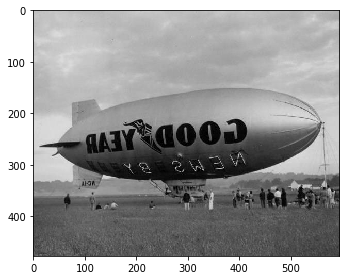

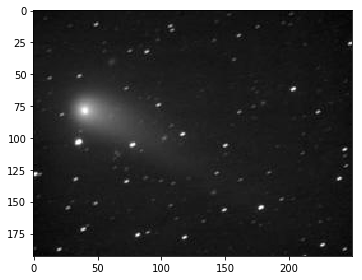

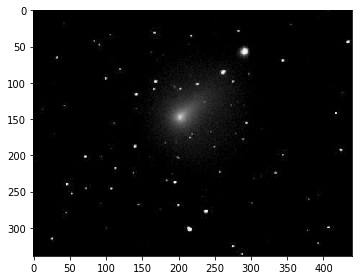

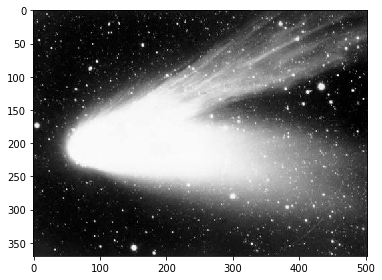

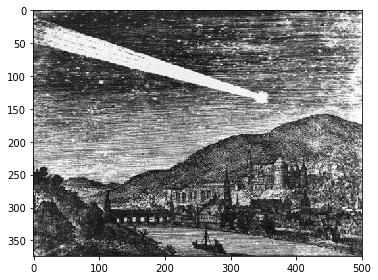

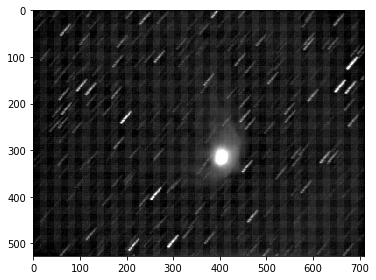

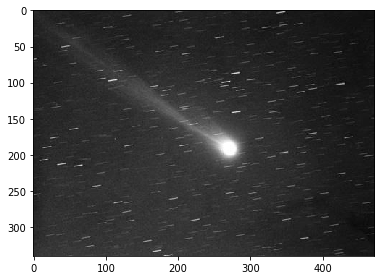

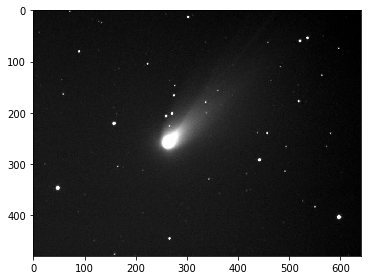

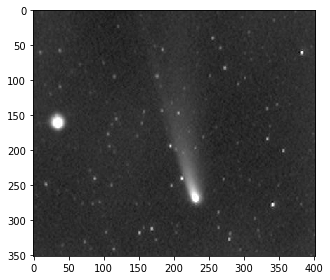

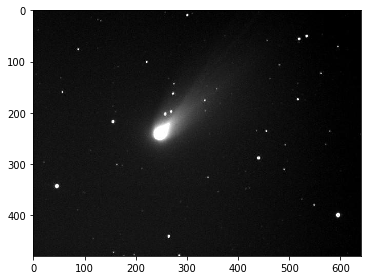

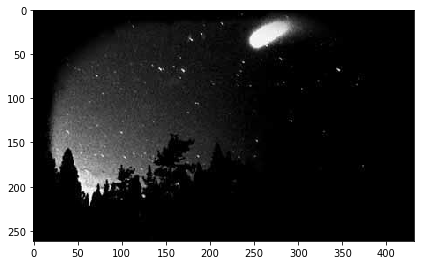

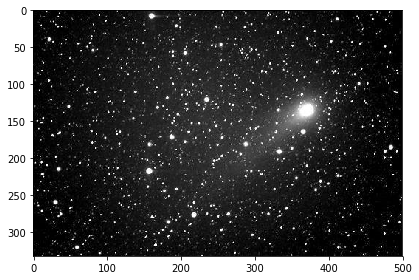

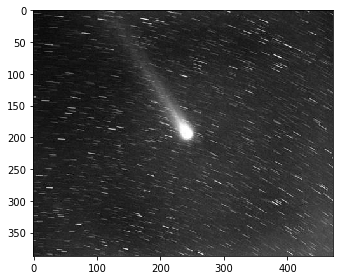

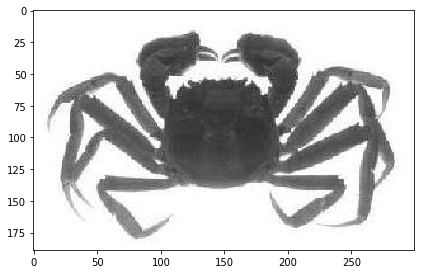

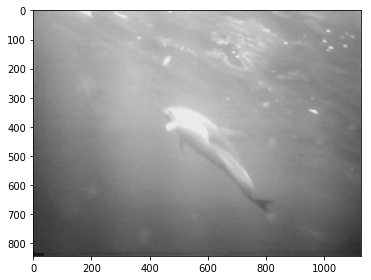

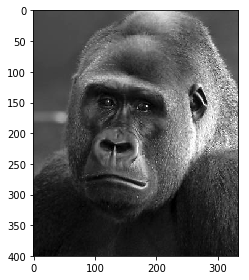

16


In [270]:
### Show the grayscale images

for x in train_df_gray.Pictures:
    skimage.io.imshow(x)
    plt.show()

In [271]:
print("Number of gray images:",len(train_df_gray))

Number of gray images: 16


In [272]:
### Explore corner detecting measures: Kitchen Rosenfeld algorithm
train_df['mean_corner_KR'] = train_df.Pictures.apply(lambda x: np.mean(ft.corner_kitchen_rosenfeld(x)))
train_df['max_corner_KR'] = train_df.Pictures.apply(lambda x: np.max(ft.corner_kitchen_rosenfeld(x)))

<h4> Graphs </h4>

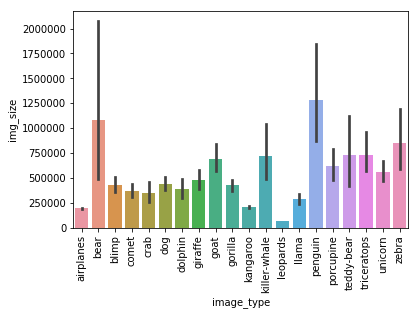

In [15]:
### image size
EDA_bar_plot(train_df,'img_size')

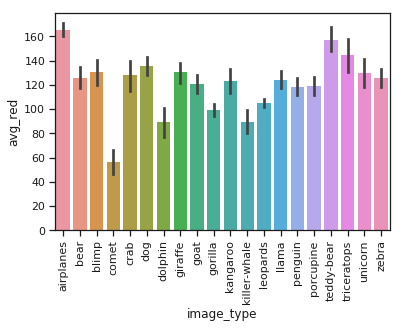

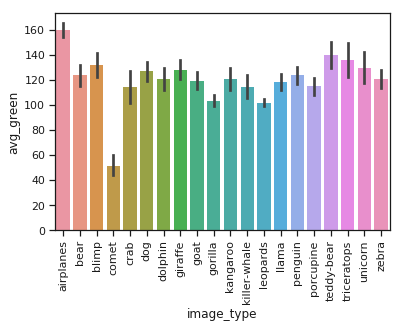

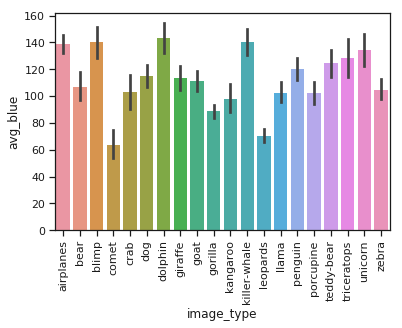

In [179]:
### Average of RGB channels
EDA_bar_plot(train_df,'avg_red')
EDA_bar_plot(train_df,'avg_green')
EDA_bar_plot(train_df,'avg_blue')

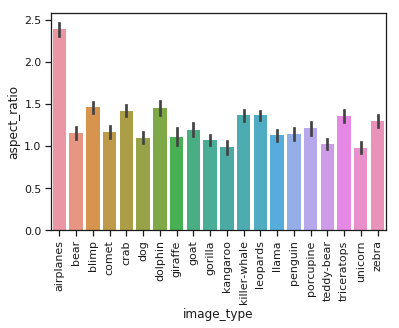

In [180]:
### Aspect ratio
EDA_bar_plot(train_df,'aspect_ratio')

In [11]:
### Calculate and plot the cross-correlations among RGB
train_df['rg_corr'] = train_df.Pictures.apply(rgcorr)
train_df['rb_corr'] = train_df.Pictures.apply(rbcorr)
train_df['gb_corr'] = train_df.Pictures.apply(gbcorr)

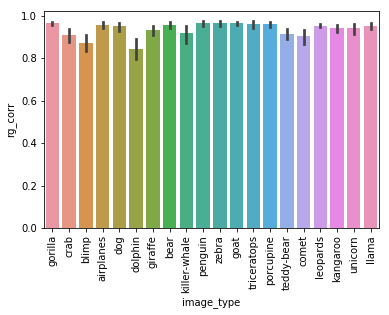

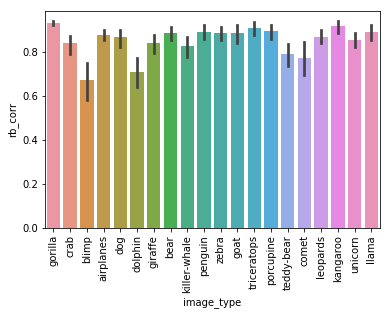

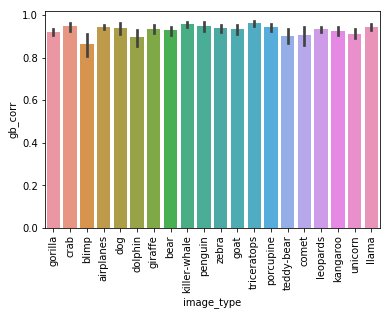

In [15]:
EDA_bar_plot(train_df,'rg_corr')
EDA_bar_plot(train_df,'rb_corr')
EDA_bar_plot(train_df,'gb_corr')

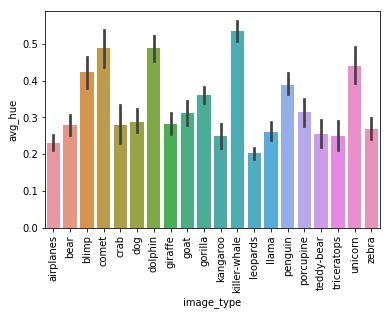

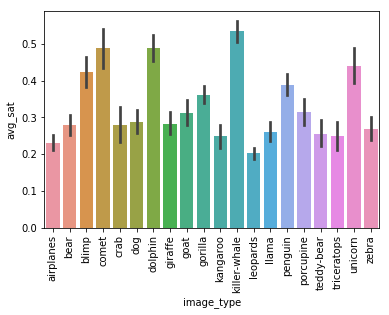

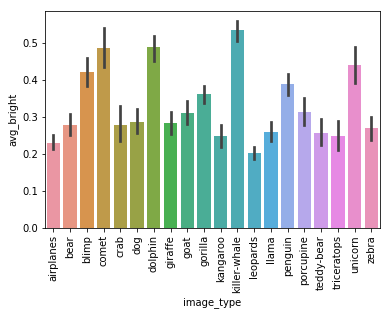

In [273]:
### HSV color space
avg_HSV_pics = train_df.Pictures.apply(avg_HSV)
train_df['avg_hue'] = avg_HSV_pics.apply(lambda x: x[0]) # 11. avg hue
train_df['avg_sat'] = avg_HSV_pics.apply(lambda x: x[0]) # 12. avg saturation
train_df['avg_bright'] = avg_HSV_pics.apply(lambda x: x[0]) # 13. avg brightness ('value')

EDA_bar_plot(train_df,'avg_hue')
EDA_bar_plot(train_df,'avg_sat')
EDA_bar_plot(train_df,'avg_bright')

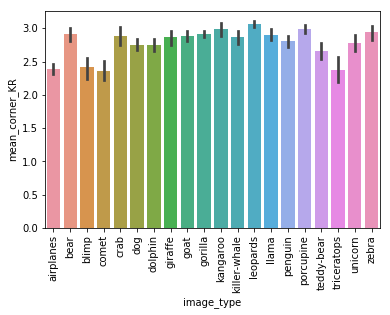

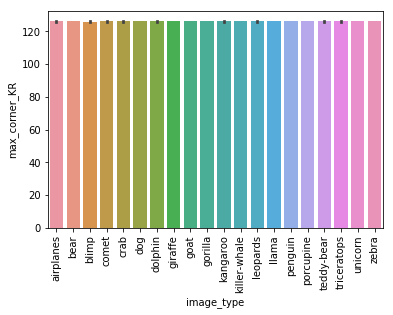

In [274]:
### Explore corner detection features. Kitchen Rosenfeld algorithm
EDA_bar_plot(train_df,'mean_corner_KR')
EDA_bar_plot(train_df,'max_corner_KR')

In [146]:
### Matrix of Hessian determinants for the three channels. 

train_df['r_hess'] = train_df.Pictures.apply(lambda x: np.mean(ft.hessian_matrix_det(x[:,:,0])))
train_df['g_hess'] = train_df.Pictures.apply(lambda x: np.mean(ft.hessian_matrix_det(x[:,:,1])))
train_df['b_hess'] = train_df.Pictures.apply(lambda x: np.mean(ft.hessian_matrix_det(x[:,:,2])))

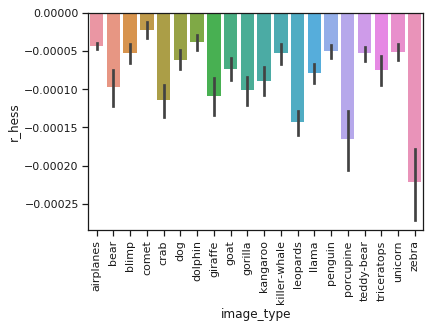

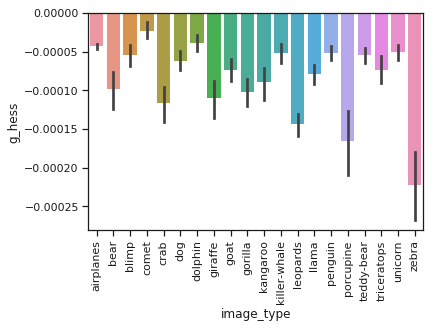

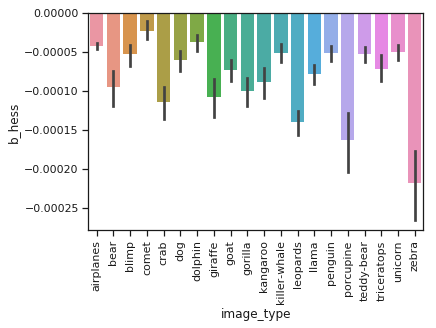

In [182]:
EDA_bar_plot(train_df,'r_hess')
EDA_bar_plot(train_df,'g_hess')
EDA_bar_plot(train_df,'b_hess')

In [184]:
### Matrix of Hessian determinants for the grayscale version of the image. 

train_df['hess'] = train_df.Pictures.apply(lambda x: np.mean(ft.hessian_matrix_det(rgb2gray(x))))

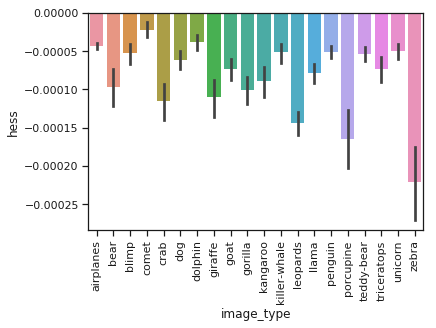

In [186]:
EDA_bar_plot(train_df,'hess')

In [164]:
### Mean of the Canny corner detection algorithm
train_df['canny'] = train_df.Pictures.apply(lambda x: np.mean(ft.canny(rgb2gray(x))))

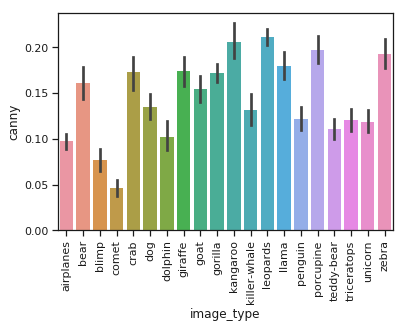

In [185]:
EDA_bar_plot(train_df,'canny')

In [209]:
### Mean of the Harris corner detection algorithm matrix

train_df['mean_harris'] = train_df.Pictures.apply(lambda x: np.mean(ft.corner_harris(rgb2gray(x))))

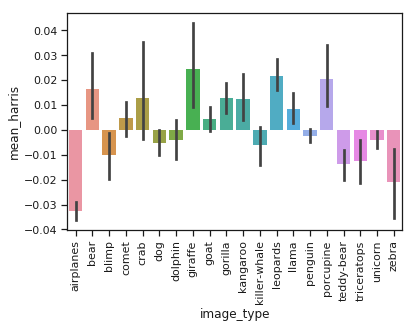

In [213]:
EDA_bar_plot(train_df,'mean_harris')

In [219]:
### Max minus min of the Harris corner detection matrix

train_df['harris_spread'] = train_df.Pictures.apply(lambda x: spread(ft.corner_harris(rgb2gray(x))))

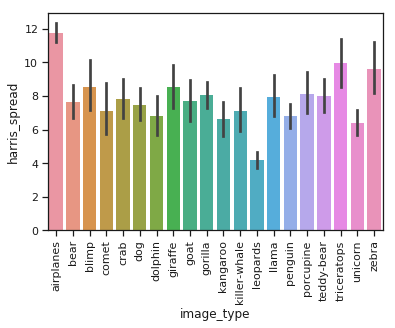

In [220]:
EDA_bar_plot(train_df,'harris_spread')

In [194]:
### Mean of the Histogram of Gradients (HOG) matrix, grayed image

train_df['avg_hog'] = train_df.Pictures.apply(lambda x: np.mean(ft.hog(rgb2gray(x))))

/Users/will/anaconda3/envs/data100/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


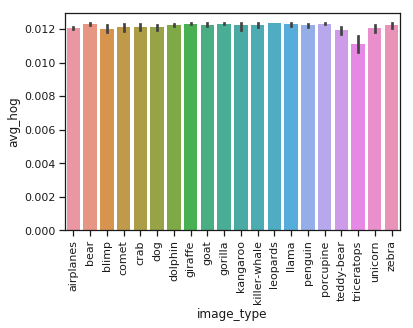

In [195]:
EDA_bar_plot(train_df,'avg_hog')

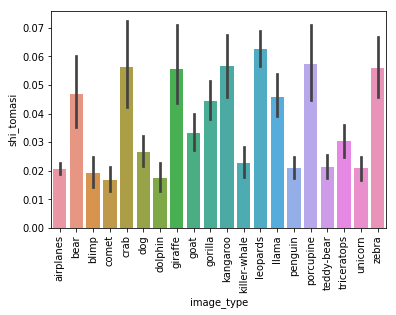

In [120]:
### Mean of the Shi-Tomasi corner detection matrix, grayed image

train_df['shi_tomasi'] = train_df.Pictures.apply(lambda x: np.mean(ft.corner_shi_tomasi(rgb2gray(x))))
EDA_bar_plot(train_df,'shi_tomasi')

In [196]:
### Maximum value of the HOG matrix, grayed image

train_df['max_hog'] = train_df.Pictures.apply(lambda x: np.max(ft.hog(rgb2gray(x))))

/Users/will/anaconda3/envs/data100/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


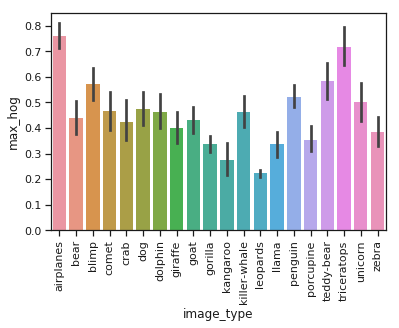

In [197]:
EDA_bar_plot(train_df,'max_hog')

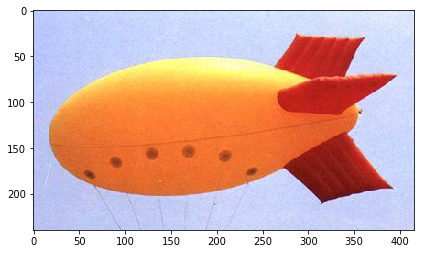

/Users/will/anaconda3/envs/data100/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/Users/will/anaconda3/envs/data100/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


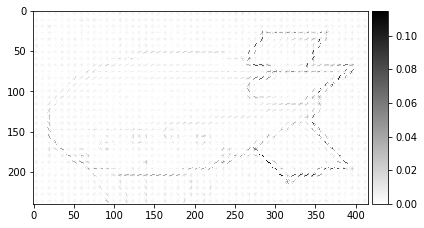

In [275]:
### Test image and visualization of the HOG.

test_image = train_df.Pictures[200]
skimage.io.imshow(test_image)
plt.savefig('test_image.png')
plt.show()
# ft.hessian_matrix_det(test_image[:,:,1])

a,hog_im=ft.hog(rgb2gray(test_image),visualise=True)
skimage.io.imshow(hog_im,cmap='gray_r')
plt.savefig("test_image_HOG.png",bbox_inches='tight')

In [49]:
### Calculate the dominant color in an image using K-means clustering of the pixels in RGB space. 
### Unfortunately this does not provide much more information than just averaging the RGB channels, and is slow.

train_df['dom_color'] = train_df.Pictures.apply(lambda x: dominant_colors(x,ncolors=1)) # first 0 is index of the color, next is index of color channel RGB

In [54]:
train_df['dom_red'] = train_df.dom_color.apply(lambda x: x[0][0])
train_df['dom_green'] = train_df.dom_color.apply(lambda x: x[0][1])
train_df['dom_blue'] = train_df.dom_color.apply(lambda x: x[0][2])

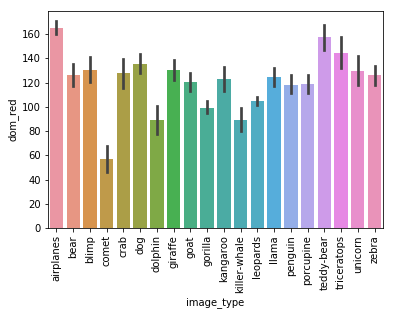

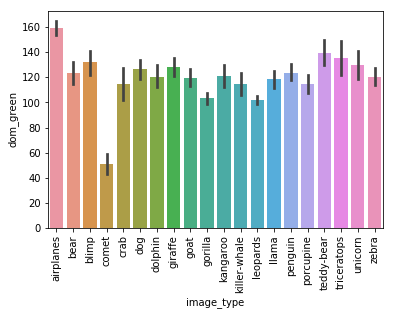

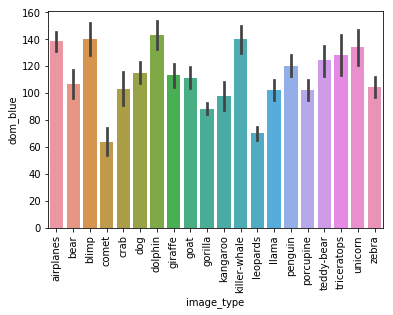

In [55]:
EDA_bar_plot(train_df,'dom_red')
EDA_bar_plot(train_df,'dom_green')
EDA_bar_plot(train_df,'dom_blue')

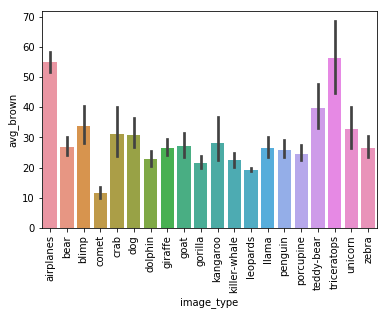

In [84]:
### Project onto "brown" for every pixel and take the average.

brown = [153, 102, 51]
train_df['avg_brown'] = train_df.Pictures.apply(lambda x: avg_color(x,brown))
EDA_bar_plot(train_df,'avg_brown')

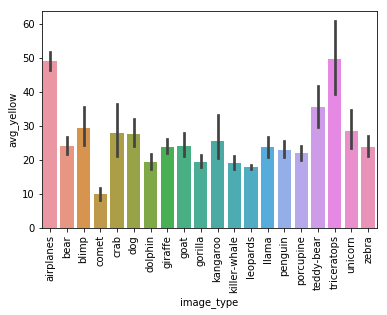

In [83]:
### Project onto "yellow" for every pixel and take the average.

yellow = [255, 255, 0]
train_df['avg_yellow'] = train_df.Pictures.apply(lambda x: avg_color(x,yellow))
EDA_bar_plot(train_df,'avg_yellow')

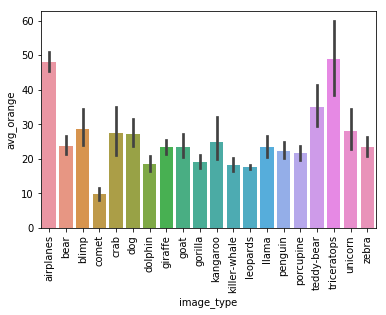

In [86]:
### Project onto "orange" for every pixel and take the average.

orange = [255, 165, 0]
train_df['avg_orange'] = train_df.Pictures.apply(lambda x: avg_color(x,orange))
EDA_bar_plot(train_df,'avg_orange')

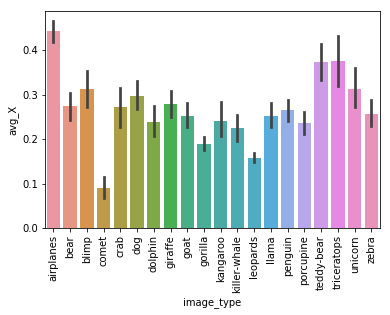

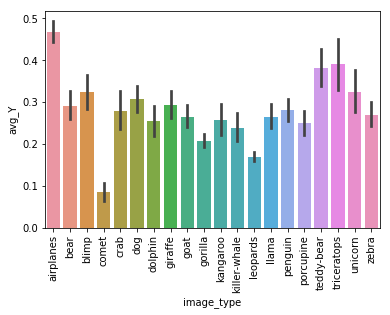

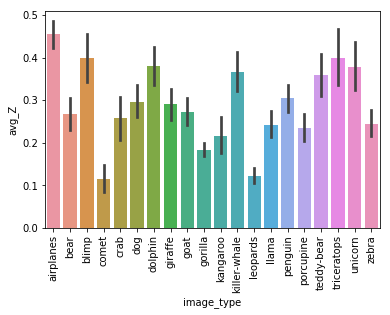

In [105]:
### Convert to XYZ color space and look at averages. XYZ aligns better with human vision than RGB/HSV.

avg_XYZ_pics = train_df.Pictures.apply(avg_XYZ)
train_df['avg_X'] = avg_XYZ_pics.apply(lambda x: x[0])
train_df['avg_Y'] = avg_XYZ_pics.apply(lambda x: x[1])
train_df['avg_Z'] = avg_XYZ_pics.apply(lambda x: x[2])

EDA_bar_plot(train_df,'avg_X')
EDA_bar_plot(train_df,'avg_Y')
EDA_bar_plot(train_df,'avg_Z')

<h4> Sources </h4>

[1] https://en.wikipedia.org/wiki/List_of_color_spaces_and_their_uses

[2] http://scikit-image.org/docs/dev/api/skimage.feature.html

[3] https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

[4] https://zeevgilovitz.com/detecting-dominant-colours-in-python

[5] https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d

[6] Grus, Joel. Data Science From Scratch: First principles with Python. Cambridge: O'Reilly, 2015. 

[7] https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html (PyTorch tutorial)

<h4> DataFrame Creation </h4>

In [232]:
def feature_frame(df,isColor=True):
    
#     train_df['shape'] = train_df.Pictures.apply(lambda x: x.shape) 
#     train_df['image_type'] = train_df.Encoding.apply(lambda x: folder_names_list[x])
#     gray = (train_df['shape'].apply(len) == 2)
    
#     train_df = train_df.sort_values('Encoding')

    train_df = df.copy()
    
    train_df['img_size'] = train_df.Pictures.apply(ft0) # 1. image size
    train_df['aspect_ratio'] = train_df.Pictures.apply(ft2) # 5. aspect ratio
    train_df['mean_corner_KR'] = train_df.Pictures.apply(lambda x: np.mean(ft.corner_kitchen_rosenfeld(x))) # 15. mean KR corner
    
    if isColor:
        train_df['avg_red'] = train_df.Pictures.apply(ft1) # 2. average red
        train_df['avg_green'] = train_df.Pictures.apply(avg_green) # 3. average green
        train_df['avg_blue'] = train_df.Pictures.apply(avg_blue) # 4. average blue
        train_df['max_hog'] = train_df.Pictures.apply(lambda x: np.max(ft.hog(rgb2gray(x)))) # 6. max gray hog
        train_df['harris_spread'] = train_df.Pictures.apply(lambda x: spread(ft.corner_harris(rgb2gray(x)))) # 7. gray harris spread
        train_df['mean_harris'] = train_df.Pictures.apply(lambda x: np.mean(ft.corner_harris(rgb2gray(x)))) # 8. gray harris mean
        train_df['canny'] = train_df.Pictures.apply(lambda x: np.mean(ft.canny(rgb2gray(x)))) # 9. avg gray canny
        train_df['hess'] = train_df.Pictures.apply(lambda x: np.mean(ft.hessian_matrix_det(rgb2gray(x)))) # 10. avg gray hessian determinant
        
        avg_HSV_pics = train_df.Pictures.apply(avg_HSV)
        train_df['avg_hue'] = avg_HSV_pics.apply(lambda x: x[0]) # 11. avg hue
        train_df['avg_sat'] = avg_HSV_pics.apply(lambda x: x[0]) # 12. avg saturation
        train_df['avg_bright'] = avg_HSV_pics.apply(lambda x: x[0]) # 13. avg brightness ('value')
        
        train_df['rb_corr'] = train_df.Pictures.apply(rbcorr) # 14. red-blue correlation
        
        avg_XYZ_pics = train_df.Pictures.apply(avg_XYZ)
        train_df['avg_X'] = avg_XYZ_pics.apply(lambda x: x[0]) # 16. avg X
        train_df['avg_Y'] = avg_XYZ_pics.apply(lambda x: x[1]) # 17. avg Y
        train_df['avg_Z'] = avg_XYZ_pics.apply(lambda x: x[2]) # 18. avg Z
        
        train_df['shi_tomasi'] = train_df.Pictures.apply(lambda x: np.mean(ft.corner_shi_tomasi(rgb2gray(x)))) # 19. shi-tomasi corner detection
        

        
#         ### optional extra color features (not as good)
#         train_df['rg_corr'] = train_df.Pictures.apply(rgcorr)
#         train_df['gb_corr'] = train_df.Pictures.apply(gbcorr)

#         dom_color = train_df.Pictures.apply(dom_color)
#         train_df['dom_red'] = dom_color.apply(lambda x: x[0][0])
#         train_df['dom_green'] = dom_color.apply(lambda x: x[0][1])
#         train_df['dom_blue'] = dom_color.apply(lambda x: x[0][2])
        
    else:
        train_df['max_hog'] = train_df.Pictures.apply(lambda x: np.max(ft.hog(x))) # 6. max gray hog
        train_df['harris_spread'] = train_df.Pictures.apply(lambda x: spread(ft.corner_harris(x))) # 7. gray harris spread
        train_df['mean_harris'] = train_df.Pictures.apply(lambda x: np.mean(ft.corner_harris(x))) # 8. gray harris mean
        train_df['canny'] = train_df.Pictures.apply(lambda x: np.mean(ft.canny(x))) # 9. avg gray canny
        train_df['hess'] = train_df.Pictures.apply(lambda x: np.mean(ft.hessian_matrix_det(x))) # 10. avg gray hessian determinant
        train_df['shi_tomasi'] = train_df.Pictures.apply(lambda x: np.mean(ft.corner_shi_tomasi(x))) # 19. shi-tomasi corner detection
        

    del train_df['Pictures'] # drop the pictures column
    if 'shape' in train_df.keys():
        del train_df['shape'] # drop the shape column
    if 'image_type' in train_df.keys():
        del train_df['image_type'] # drop the image type column
    
    return train_df
    #Returns data-frame with all the features now inside, and calculated

In [257]:
## reload the raw training data

### Load the training data frame
### WARNING - VERY SLOW
data_file = Path('/Users/will/Documents/Berkeley/Classes/DS100/Projects/GradProject', "labeled_pics.hdf") # Path of hdf file
train_df = pd.read_hdf(data_file, "starting_data")

train_df['shape'] = train_df.Pictures.apply(lambda x: x.shape)
train_df['image_type'] = train_df.Encoding.apply(lambda x: folder_names_list[x])
train_df = train_df.sort_values('image_type')

### Handle gray images and produce more gray images from the colored ones.
gray = (train_df['shape'].apply(len) == 2) ## where gray images are
train_df_gray = train_df[gray] # gray images
train_df = train_df[~gray] # train_df is now only color

train_df_grayed = train_df.copy() ## train_df_gray is all gray images + grayed(color images)
train_df_grayed['Pictures'] = train_df_grayed.Pictures.apply(rgb2gray)
train_df_gray = train_df_gray.append(train_df_grayed,ignore_index=True)

train_df.head()

,Pictures,Encoding,shape,image_type
284,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,"(228, 396, 3)",airplanes
314,"[[[255, 255, 255], [253, 254, 255], [248, 255,...",0,"(195, 396, 3)",airplanes
313,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,"(205, 392, 3)",airplanes
311,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,"(192, 392, 3)",airplanes
310,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,"(155, 391, 3)",airplanes


In [259]:
# features = feature_frame(train_df,isColor=True) ## color
features_gray = feature_frame(train_df_gray,isColor=False) ## gray

/Users/will/anaconda3/envs/data100/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [133]:
features.head()

,Encoding,img_size,aspect_ratio,mean_corner_KR,avg_red,avg_green,avg_blue,max_hog,harris_spread,mean_harris,canny,hess,avg_hue,avg_sat,avg_bright,rb_corr,avg_X,avg_Y,avg_Z,shi_tomasi
284,0,270864,1.736842,2.451843,179.680711,193.105374,209.171983,0.530403,10.131628,-0.031242,0.040626,-0.000023,0.517861,0.517861,0.517861,0.948369,0.588730,0.632071,0.832910,0.008667
314,0,231660,2.030769,2.855736,141.909182,130.856617,99.079850,0.657464,16.233875,-0.012490,0.133748,-0.000067,0.216932,0.216932,0.216932,0.703549,0.324436,0.343123,0.322138,0.036080
313,0,241080,1.912195,2.352852,145.904517,146.758860,128.423693,0.949758,12.075943,-0.035977,0.078758,-0.000032,0.245594,0.245594,0.245594,0.943778,0.379596,0.404632,0.419247,0.012163
311,0,225792,2.041667,2.168960,183.918208,175.641834,155.193094,0.946046,11.222953,-0.045281,0.110491,-0.000053,0.206193,0.206193,0.206193,0.912276,0.540097,0.571119,0.549690,0.022417
310,0,181815,2.522581,2.413867,178.175992,175.974095,155.460507,0.965003,10.131628,-0.032330,0.113060,-0.000047,0.219527,0.219527,0.219527,0.910976,0.496570,0.528559,0.529819,0.024214


In [260]:
features_gray.head()

,Encoding,img_size,aspect_ratio,mean_corner_KR,max_hog,harris_spread,mean_harris,canny,hess,shi_tomasi
0,2,283815,1.247379,4.031068,0.579653,3.675247,-0.004278,0.051142,-0.000023,0.007954
1,3,48250,1.295337,4.719046,0.294566,7.835766,0.017233,0.018466,-0.000026,0.013990
2,3,149160,1.297935,1.115930,0.999998,11.014305,0.015154,0.006382,-0.000014,0.009367
3,3,186110,1.359459,3.451730,0.999925,8.970476,0.023581,0.086879,-0.000052,0.030689
4,3,187000,1.336898,3.308591,0.157487,9.532335,0.050680,0.284872,-0.000175,0.113499


In [262]:
### Save the data frames

data_file = Path('/Users/will/Documents/Berkeley/Classes/DS100/Projects/GradProject', "features.hdf") # Path of hdf file
features.to_hdf(data_file,"features")
features_gray.to_hdf(data_file,"features_gray")

In [153]:
### While we're at it, also save test data feature frame

In [235]:
from skimage import io
def read_organize_testdata(file_path):
    #Fill this function out, should return a dataframe with picture object, and correct encoding
    
    ### Create a dictionary to assign numbers to folder names
    folder_names_list = ['airplanes', 'bear', 'blimp', 'comet', 'crab', 'dog', 'dolphin', 'giraffe', 'goat', 'gorilla', 'kangaroo', 'killer-whale', 'leopards', 'llama', 'penguin', 'porcupine', 'teddy-bear', 'triceratops', 'unicorn', 'zebra']
    encoding_list = range(20)
    encoding = dict(zip(folder_names_list, encoding_list))
    
#     rootdir = '/Users/will/Documents/Berkeley/Classes/DS100/Projects/GradProject/20_categories_training/'
    pictures = []
    pic_ids = []
    for subdir, dirs, files in os.walk(file_path):
        for file in files:
            if file[0]!='.': ## avoid hidden files               
                pic = io.imread(os.path.join(subdir, file))
                pictures.append(pic)
                
                pic_id = int(file.split('(')[1].split(')')[0]) ## extracts the number of the picture
                pic_ids.append(pic_id)
    
    df = pd.DataFrame()
    df['Pictures'] = pictures
    df['pic_id'] = pic_ids
    df = df.set_index('pic_id')
    df = df.sort_index()
    return df  

In [236]:
test_data_path = '/Users/will/Documents/Berkeley/Classes/DS100/Projects/GradProject/20_Validation/'
test_data = read_organize_testdata(test_data_path)
test_data.head()

,Pictures
pic_id,
1,"[[[48, 53, 57], [52, 57, 63], [54, 59, 65], [4..."
2,"[[[10, 15, 19], [10, 15, 19], [11, 16, 19], [1..."
3,"[[[232, 231, 247], [250, 249, 255], [235, 234,..."
4,"[[[97, 75, 77], [98, 76, 78], [99, 77, 79], [1..."
5,"[[[19, 46, 55], [19, 46, 53], [20, 47, 54], [2..."


In [237]:
### Save the test data frame 

data_file = Path('/Users/will/Documents/Berkeley/Classes/DS100/Projects/GradProject', "test_data.hdf") # Path of hdf file
test_data.to_hdf(data_file, "test_data")

/Users/will/anaconda3/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['Pictures']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [238]:
test_data_color = test_data[test_data.Pictures.apply(lambda x: len(x.shape)) == 3]
test_data_gray = test_data[~(test_data.Pictures.apply(lambda x: len(x.shape)) == 3)]

In [239]:
test_data_color.head()

,Pictures
pic_id,
1,"[[[48, 53, 57], [52, 57, 63], [54, 59, 65], [4..."
2,"[[[10, 15, 19], [10, 15, 19], [11, 16, 19], [1..."
3,"[[[232, 231, 247], [250, 249, 255], [235, 234,..."
4,"[[[97, 75, 77], [98, 76, 78], [99, 77, 79], [1..."
5,"[[[19, 46, 55], [19, 46, 53], [20, 47, 54], [2..."


In [240]:
test_features_color = feature_frame(test_data_color)
test_features_gray = feature_frame(test_data_gray,isColor=False)

/Users/will/anaconda3/envs/data100/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [243]:
### Save the test features frames

data_file = Path('/Users/will/Documents/Berkeley/Classes/DS100/Projects/GradProject', "test_features.hdf") # Path of hdf file
test_features_color.to_hdf(data_file, "test_features_color")
test_features_gray.to_hdf(data_file,"test_features_gray")